In [1]:
import ROOT

Module libc not found.


Welcome to JupyROOT 6.24/07


In [2]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists

import read_config_utils as cu

In [4]:
import sys
import time

import gc

In [5]:
#input_dir = 'output-files-bootstrap-test6b-6d'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'


#input_dir = 'bootstrap-toy-study6b-2d-4c'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c'

#input_dir = 'freshtoys-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model'

#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-02'




#input_dir = 'bootstrap-toy-study6b-1d-1a'
#input_dir = 'bootstrap-toy-study6b-1d-1a-badres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-goodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-verygoodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-perfect'#



#input_dir = 'fit-pdf-toy-study-2d-1a'

#input_dir = 'fit-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution-5k-toys'

#input_dir = 'hist-pdf-toy-study-1d-1a-badres'

#input_dir = 'hist-pdf-toy-study-1d-1b'

input_dir = 'bootstrap-toy-study8a-1d-1d'

#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'

#---


points_file = 'train-and-true-samples.npy'





In [6]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [7]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [8]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

In [9]:
with open('%s/%s' % (input_dir, points_file),'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)


In [10]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 539 bootstrap samples.




## Read in the main OmniFold ouput for the fake data and fit it before doing the bootstraps

In [11]:
fname = '%s/omnifold-output-weights.npy' % (input_dir)
#fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, 0)  

print('\n\n Reading in %s for weights in test fit.\n\n' % fname)
with open(fname,'rb') as f :
    sample_weights = np.load(f)



 Reading in bootstrap-toy-study8a-1d-1d/omnifold-output-weights.npy for weights in test fit.




In [12]:

nmcevts = len(train_pts)

print( "train_pts shape:  %s" % str(train_pts.shape))
print( "weights:  %s" % str(sample_weights.shape))

print( "number of MC events: %d" % nmcevts)

train_pts shape:  (100000, 1)
weights:  (100000,)
number of MC events: 100000


In [13]:


true_cov  = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
   

   0,  0 : diagonal    0.8100


## Read in the simple calculation results to set the parameter limits

In [14]:
with open( '%s/simple-calc-results.npy' % input_dir, 'rb') as f :
    sc_ave_mean_val = np.load(f, allow_pickle=True )
    sc_ave_mean_rms = np.load(f, allow_pickle=True)
    sc_ave_cov_val  = np.load(f, allow_pickle=True)    
    sc_ave_cov_rms  = np.load(f, allow_pickle=True )



In [15]:
sc_ave_cov_val

array([[0.81277252]])

In [16]:
print('\n\n')
print('  Simple direct calculation results from the bootstrap samples.\n')

for fi in range(ndim) :
    print('  feature %d  mean:   %8.4f  (true %8.4f) RMS  %8.4f'
         % (fi, sc_ave_mean_val[fi], true_mu[fi], sc_ave_mean_rms[fi]) )
    
print('\n')

for i in range(ndim) :
    for j in range(i,ndim) :
        print('   %d, %d  cov:   %8.4f  (true %8.4f) RMS  %8.4f'
              % ( i, j, sc_ave_cov_val[i][j], true_cov[i,j], sc_ave_cov_rms[i][j]) )

print('\n\n')




  Simple direct calculation results from the bootstrap samples.

  feature 0  mean:     0.2000  (true   0.2000) RMS    0.0112


   0, 0  cov:     0.8128  (true   0.8100) RMS    0.0143





In [17]:
width_factor_mean = 10
width_factor_cov = 10

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [18]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = sc_ave_cov_val[i][j]
        minval = sc_ave_cov_val[i][j] - width_factor_cov * sc_ave_cov_rms[i][j]
        maxval = sc_ave_cov_val[i][j] + width_factor_cov * sc_ave_cov_rms[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            ######covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], 0.02, 2.0 )           
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            ######covdict[vname] =   ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], -1.1, 1.1 ) 
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        


 parameter cov00  min   0.6694, max   0.9562
RooRealVar::cov00 = 0.812773  L(0.669376 - 0.956169) 


In [19]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [20]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.813


### The Dict keeps the variables defined in memory

In [21]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = sc_ave_mean_val[i]
    minval = sc_ave_mean_val[i] - width_factor_mean * sc_ave_mean_rms[i]
    maxval = sc_ave_mean_val[i] + width_factor_mean * sc_ave_mean_rms[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    ##########muDict[vname] =  ROOT.RooRealVar( vname, vname, true_mu[i], -2., 2. )
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.0876, max   0.3124
RooRealVar::mu_x0 = 0.199987  L(0.0875719 - 0.312401) 


In [22]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.812773
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8128 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |       1.23 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [23]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0


In [24]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))
ROOT.SetOwnership( data_test, True )

In [25]:
%%time

for i in range( len(sample_weights) ) :
    if i % (len(sample_weights)/100 ) == 0 : print( " %9d / %9d  (%6.0f)%%" % (i, len(sample_weights), 100*i/len(sample_weights)))
    for j in range( ndim ) :
        xVec[j].setVal( train_pts[i,j] )
    weight.setVal( sample_weights[i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

         0 /    100000  (     0)%
      1000 /    100000  (     1)%
      2000 /    100000  (     2)%
      3000 /    100000  (     3)%
      4000 /    100000  (     4)%
      5000 /    100000  (     5)%
      6000 /    100000  (     6)%
      7000 /    100000  (     7)%
      8000 /    100000  (     8)%
      9000 /    100000  (     9)%
     10000 /    100000  (    10)%
     11000 /    100000  (    11)%
     12000 /    100000  (    12)%
     13000 /    100000  (    13)%
     14000 /    100000  (    14)%
     15000 /    100000  (    15)%
     16000 /    100000  (    16)%
     17000 /    100000  (    17)%
     18000 /    100000  (    18)%
     19000 /    100000  (    19)%
     20000 /    100000  (    20)%
     21000 /    100000  (    21)%
     22000 /    100000  (    22)%
     23000 /    100000  (    23)%
     24000 /    100000  (    24)%
     25000 /    100000  (    25)%
     26000 /    100000  (    26)%
     27000 /    100000  (    27)%
     28000 /    100000  (    28)%
     29000 /  

In [26]:
data_test

In [27]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 100000 entries
  Observables: 
    1)  x0 = -1.98345  L(-10 - 10)  "x0"
  Dataset variable "weight" is interpreted as the event weight


In [28]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = -0.144454


In [29]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        #########covRAL.find(vname).setConstant()

In [30]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.812773


In [31]:
covRAL.find("cov00").isConstant()

False

In [32]:
%%time

rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
ROOT.SetOwnership( rfr, True )


CPU times: user 16 ms, sys: 283 ms, total: 299 ms
Wall time: 645 ms
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
  copy constructor, Setting _prevCovVals[0] to 0.812773
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 28 remote server process.
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 cov00        8.12773e-01  2.86792e-02    6.69376e-01  9.56169e-01
     2 mu_x0        1.99987e-01  2.24830e-02    8.75719e-02  3.12401e-01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINI

In [33]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.815352 +/- 0.0114678


In [34]:
for i in range(ndim) :
    fit_mean = muDict["mu_x%d" % i].getVal()
    fit_mean_err = muDict["mu_x%d" % i].getError()
    print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
          (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

print("\n")

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        fit_cov = covdict["cov%d%d" % (i,j)].getVal()
        fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
        print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
               (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )

   0 :  mu =   0.1863   (true   0.2000) err   0.0090  diff  -0.0137   diff/err  -1.53


  0,  0 :  cov    0.8154  (true   0.8100) err   0.0115  diff   0.0054   diff/err   0.47


In [35]:

del data_test
del rfr
gc.collect()

0

In [36]:
fit_results_mean_val = np.zeros( shape=(ndim, n_samples ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_samples ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_samples ) )

In [37]:
%%time

#### TESTING
###n_samples = 1

for bi in range( n_samples ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2011   (true   0.2000) err   0.0090  diff   0.0011   diff/err   0.12


  0,  0 :  cov    0.8210  (true   0.8100) err   0.0115  diff   0.0110   diff/err   0.96
Cleaning up.


 --- bootstrap sample   1
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1821   (true   0.2000) err   0.0091  diff  -0.0179   diff/err  -1.97


  0,  0 :  cov    0.8228  (true   0.8100) err   0.0116  diff   0.0128   diff/err   1.10
Cleaning up.


 --- bootstrap sample   2
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1912   (true   0.2000) err   0.0089  diff  -0.0088   diff/err  -0.98


  0,  0 :  cov    0.8108  (true   0.8100) err   0.0114

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1796   (true   0.2000) err   0.0090  diff  -0.0204   diff/err  -2.27


  0,  0 :  cov    0.8043  (true   0.8100) err   0.0114  diff  -0.0057   diff/err  -0.50
Cleaning up.


 --- bootstrap sample  25
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-025.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2012   (true   0.2000) err   0.0091  diff   0.0012   diff/err   0.13


  0,  0 :  cov    0.8209  (true   0.8100) err   0.0116  diff   0.0109   diff/err   0.94
Cleaning up.


 --- bootstrap sample  26
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-026.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1868   (true   0.2000) err   0.0090  diff  -0.0132   diff/err  -1.47


  0,  0 :  cov    0.8135  (true   0.8100) err   0.0115  diff   0.0035   diff/err  

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-048.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1950   (true   0.2000) err   0.0090  diff  -0.0050   diff/err  -0.55


  0,  0 :  cov    0.8210  (true   0.8100) err   0.0116  diff   0.0110   diff/err   0.95
Cleaning up.


 --- bootstrap sample  49
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-049.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2087   (true   0.2000) err   0.0091  diff   0.0087   diff/err   0.95


  0,  0 :  cov    0.8266  (true   0.8100) err   0.0117  diff   0.0166   diff/err   1.42
Cleaning up.


 --- bootstrap sample  50
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-050.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1902   (true   0.2000) err   0.0091  diff  -0.0098   diff/err  -1.08


  0,  0 :  cov    0.8191  (true   0.8100) err   0.0116  diff   0.0091   diff/err  

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-072.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2000   (true   0.2000) err   0.0090  diff   0.0000   diff/err   0.00


  0,  0 :  cov    0.8052  (true   0.8100) err   0.0114  diff  -0.0048   diff/err  -0.42
Cleaning up.


 --- bootstrap sample  73
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-073.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1974   (true   0.2000) err   0.0091  diff  -0.0026   diff/err  -0.29


  0,  0 :  cov    0.8352  (true   0.8100) err   0.0118  diff   0.0252   diff/err   2.14
Cleaning up.


 --- bootstrap sample  74
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-074.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1779   (true   0.2000) err   0.0090  diff  -0.0221   diff/err  -2.45


  0,  0 :  cov    0.8116  (true   0.8100) err   0.0115  diff   0.0016   diff/err  



 --- bootstrap sample  96
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-096.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1864   (true   0.2000) err   0.0089  diff  -0.0136   diff/err  -1.53


  0,  0 :  cov    0.7937  (true   0.8100) err   0.0112  diff  -0.0163   diff/err  -1.46
Cleaning up.


 --- bootstrap sample  97
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-097.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2042   (true   0.2000) err   0.0090  diff   0.0042   diff/err   0.46


  0,  0 :  cov    0.8243  (true   0.8100) err   0.0116  diff   0.0143   diff/err   1.24
Cleaning up.


 --- bootstrap sample  98
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-098.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1926   (true   0.2000) err   0.0090  diff  -0.0074   diff/err  -0.82


  0,  0 :  cov    0.8076  (true   0.8100) err   0.0114



 --- bootstrap sample 120
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-120.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2071   (true   0.2000) err   0.0090  diff   0.0071   diff/err   0.80


  0,  0 :  cov    0.7956  (true   0.8100) err   0.0113  diff  -0.0144   diff/err  -1.28
Cleaning up.


 --- bootstrap sample 121
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-121.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2067   (true   0.2000) err   0.0090  diff   0.0067   diff/err   0.75


  0,  0 :  cov    0.8040  (true   0.8100) err   0.0114  diff  -0.0060   diff/err  -0.53
Cleaning up.


 --- bootstrap sample 122
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-122.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1810   (true   0.2000) err   0.0090  diff  -0.0190   diff/err  -2.10


  0,  0 :  cov    0.8125  (true   0.8100) err   0.0115



 --- bootstrap sample 144
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-144.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1917   (true   0.2000) err   0.0089  diff  -0.0083   diff/err  -0.93


  0,  0 :  cov    0.7999  (true   0.8100) err   0.0113  diff  -0.0101   diff/err  -0.90
Cleaning up.


 --- bootstrap sample 145
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-145.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1842   (true   0.2000) err   0.0090  diff  -0.0158   diff/err  -1.76


  0,  0 :  cov    0.8105  (true   0.8100) err   0.0115  diff   0.0005   diff/err   0.04
Cleaning up.


 --- bootstrap sample 146
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-146.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2172   (true   0.2000) err   0.0090  diff   0.0172   diff/err   1.90


  0,  0 :  cov    0.8256  (true   0.8100) err   0.0116



 --- bootstrap sample 168
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-168.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1897   (true   0.2000) err   0.0091  diff  -0.0103   diff/err  -1.14


  0,  0 :  cov    0.8179  (true   0.8100) err   0.0116  diff   0.0079   diff/err   0.68
Cleaning up.


 --- bootstrap sample 169
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-169.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2181   (true   0.2000) err   0.0089  diff   0.0181   diff/err   2.04


  0,  0 :  cov    0.8065  (true   0.8100) err   0.0113  diff  -0.0035   diff/err  -0.31
Cleaning up.


 --- bootstrap sample 170
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-170.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2204   (true   0.2000) err   0.0090  diff   0.0204   diff/err   2.26


  0,  0 :  cov    0.8118  (true   0.8100) err   0.0115



 --- bootstrap sample 192
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-192.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2036   (true   0.2000) err   0.0089  diff   0.0036   diff/err   0.40


  0,  0 :  cov    0.7947  (true   0.8100) err   0.0112  diff  -0.0153   diff/err  -1.36
Cleaning up.


 --- bootstrap sample 193
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-193.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2163   (true   0.2000) err   0.0090  diff   0.0163   diff/err   1.80


  0,  0 :  cov    0.8213  (true   0.8100) err   0.0116  diff   0.0113   diff/err   0.98
Cleaning up.


 --- bootstrap sample 194
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-194.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1891   (true   0.2000) err   0.0090  diff  -0.0109   diff/err  -1.21


  0,  0 :  cov    0.8047  (true   0.8100) err   0.0114

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-216.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1738   (true   0.2000) err   0.0087  diff  -0.0262   diff/err  -3.00


  0,  0 :  cov    0.7672  (true   0.8100) err   0.0108  diff  -0.0428   diff/err  -3.97
Cleaning up.


 --- bootstrap sample 217
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-217.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2037   (true   0.2000) err   0.0090  diff   0.0037   diff/err   0.41


  0,  0 :  cov    0.8168  (true   0.8100) err   0.0115  diff   0.0068   diff/err   0.59
Cleaning up.


 --- bootstrap sample 218
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-218.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2069   (true   0.2000) err   0.0091  diff   0.0069   diff/err   0.76


  0,  0 :  cov    0.8108  (true   0.8100) err   0.0115  diff   0.0008   diff/err  



 --- bootstrap sample 240
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-240.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1823   (true   0.2000) err   0.0091  diff  -0.0177   diff/err  -1.95


  0,  0 :  cov    0.8211  (true   0.8100) err   0.0116  diff   0.0111   diff/err   0.95
Cleaning up.


 --- bootstrap sample 241
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-241.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1835   (true   0.2000) err   0.0089  diff  -0.0165   diff/err  -1.86


  0,  0 :  cov    0.7887  (true   0.8100) err   0.0111  diff  -0.0213   diff/err  -1.91
Cleaning up.


 --- bootstrap sample 242
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-242.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2178   (true   0.2000) err   0.0090  diff   0.0178   diff/err   1.98


  0,  0 :  cov    0.7989  (true   0.8100) err   0.0113



 --- bootstrap sample 264
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-264.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2072   (true   0.2000) err   0.0091  diff   0.0072   diff/err   0.78


  0,  0 :  cov    0.8327  (true   0.8100) err   0.0118  diff   0.0227   diff/err   1.93
Cleaning up.


 --- bootstrap sample 265
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-265.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1821   (true   0.2000) err   0.0089  diff  -0.0179   diff/err  -2.01


  0,  0 :  cov    0.7922  (true   0.8100) err   0.0112  diff  -0.0178   diff/err  -1.58
Cleaning up.


 --- bootstrap sample 266
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-266.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1915   (true   0.2000) err   0.0090  diff  -0.0085   diff/err  -0.94


  0,  0 :  cov    0.8073  (true   0.8100) err   0.0114

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-288.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2058   (true   0.2000) err   0.0090  diff   0.0058   diff/err   0.65


  0,  0 :  cov    0.8012  (true   0.8100) err   0.0114  diff  -0.0088   diff/err  -0.78
Cleaning up.


 --- bootstrap sample 289
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-289.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1887   (true   0.2000) err   0.0089  diff  -0.0113   diff/err  -1.27


  0,  0 :  cov    0.8063  (true   0.8100) err   0.0114  diff  -0.0037   diff/err  -0.33
Cleaning up.


 --- bootstrap sample 290
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-290.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1982   (true   0.2000) err   0.0091  diff  -0.0018   diff/err  -0.20


  0,  0 :  cov    0.8307  (true   0.8100) err   0.0117  diff   0.0207   diff/err  

   0 :  mu =   0.1925   (true   0.2000) err   0.0091  diff  -0.0075   diff/err  -0.82


  0,  0 :  cov    0.8173  (true   0.8100) err   0.0116  diff   0.0073   diff/err   0.63
Cleaning up.


 --- bootstrap sample 312
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-312.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1866   (true   0.2000) err   0.0091  diff  -0.0134   diff/err  -1.48


  0,  0 :  cov    0.8225  (true   0.8100) err   0.0116  diff   0.0125   diff/err   1.07
Cleaning up.


 --- bootstrap sample 313
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-313.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1981   (true   0.2000) err   0.0091  diff  -0.0019   diff/err  -0.20


  0,  0 :  cov    0.8289  (true   0.8100) err   0.0117  diff   0.0189   diff/err   1.62
Cleaning up.


 --- bootstrap sample 314
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-314.npy
Filling 

Cleaning up.


 --- bootstrap sample 335
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-335.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2117   (true   0.2000) err   0.0089  diff   0.0117   diff/err   1.31


  0,  0 :  cov    0.8054  (true   0.8100) err   0.0113  diff  -0.0046   diff/err  -0.41
Cleaning up.


 --- bootstrap sample 336
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-336.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1933   (true   0.2000) err   0.0090  diff  -0.0067   diff/err  -0.74


  0,  0 :  cov    0.8125  (true   0.8100) err   0.0115  diff   0.0025   diff/err   0.22
Cleaning up.


 --- bootstrap sample 337
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-337.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2056   (true   0.2000) err   0.0091  diff   0.0056   diff/err   0.62


  0,  0 :  cov    0.8115  (true   0.8100)

   0 :  mu =   0.1916   (true   0.2000) err   0.0090  diff  -0.0084   diff/err  -0.94


  0,  0 :  cov    0.8054  (true   0.8100) err   0.0114  diff  -0.0046   diff/err  -0.41
Cleaning up.


 --- bootstrap sample 359
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-359.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1917   (true   0.2000) err   0.0091  diff  -0.0083   diff/err  -0.91


  0,  0 :  cov    0.8260  (true   0.8100) err   0.0117  diff   0.0160   diff/err   1.37
Cleaning up.


 --- bootstrap sample 360
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-360.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2204   (true   0.2000) err   0.0090  diff   0.0204   diff/err   2.26


  0,  0 :  cov    0.8199  (true   0.8100) err   0.0116  diff   0.0099   diff/err   0.86
Cleaning up.


 --- bootstrap sample 361
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-361.npy
Filling 

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-382.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1959   (true   0.2000) err   0.0090  diff  -0.0041   diff/err  -0.46


  0,  0 :  cov    0.8175  (true   0.8100) err   0.0115  diff   0.0075   diff/err   0.65
Cleaning up.


 --- bootstrap sample 383
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-383.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1916   (true   0.2000) err   0.0091  diff  -0.0084   diff/err  -0.93


  0,  0 :  cov    0.8307  (true   0.8100) err   0.0117  diff   0.0207   diff/err   1.77
Cleaning up.


 --- bootstrap sample 384
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-384.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1712   (true   0.2000) err   0.0088  diff  -0.0288   diff/err  -3.26


  0,  0 :  cov    0.7926  (true   0.8100) err   0.0111  diff  -0.0174   diff/err  



 --- bootstrap sample 406
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-406.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1916   (true   0.2000) err   0.0090  diff  -0.0084   diff/err  -0.93


  0,  0 :  cov    0.8146  (true   0.8100) err   0.0115  diff   0.0046   diff/err   0.39
Cleaning up.


 --- bootstrap sample 407
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-407.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2179   (true   0.2000) err   0.0091  diff   0.0179   diff/err   1.97


  0,  0 :  cov    0.8233  (true   0.8100) err   0.0116  diff   0.0133   diff/err   1.14
Cleaning up.


 --- bootstrap sample 408
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-408.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2136   (true   0.2000) err   0.0089  diff   0.0136   diff/err   1.53


  0,  0 :  cov    0.7948  (true   0.8100) err   0.0112

 --- bootstrap sample 430
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-430.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2066   (true   0.2000) err   0.0089  diff   0.0066   diff/err   0.74


  0,  0 :  cov    0.7987  (true   0.8100) err   0.0113  diff  -0.0113   diff/err  -1.01
Cleaning up.


 --- bootstrap sample 431
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-431.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1961   (true   0.2000) err   0.0091  diff  -0.0039   diff/err  -0.43


  0,  0 :  cov    0.8377  (true   0.8100) err   0.0118  diff   0.0277   diff/err   2.35
Cleaning up.


 --- bootstrap sample 432
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-432.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2037   (true   0.2000) err   0.0089  diff   0.0037   diff/err   0.42


  0,  0 :  cov    0.7917  (true   0.8100) err   0.0112  

 --- bootstrap sample 454
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-454.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2048   (true   0.2000) err   0.0089  diff   0.0048   diff/err   0.54


  0,  0 :  cov    0.8003  (true   0.8100) err   0.0113  diff  -0.0097   diff/err  -0.86
Cleaning up.


 --- bootstrap sample 455
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-455.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1864   (true   0.2000) err   0.0092  diff  -0.0136   diff/err  -1.48


  0,  0 :  cov    0.8407  (true   0.8100) err   0.0119  diff   0.0307   diff/err   2.58
Cleaning up.


 --- bootstrap sample 456
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-456.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1896   (true   0.2000) err   0.0091  diff  -0.0104   diff/err  -1.14


  0,  0 :  cov    0.8364  (true   0.8100) err   0.0118  

   0 :  mu =   0.2076   (true   0.2000) err   0.0091  diff   0.0076   diff/err   0.83


  0,  0 :  cov    0.8253  (true   0.8100) err   0.0117  diff   0.0153   diff/err   1.30
Cleaning up.


 --- bootstrap sample 478
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-478.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1966   (true   0.2000) err   0.0090  diff  -0.0034   diff/err  -0.38


  0,  0 :  cov    0.7975  (true   0.8100) err   0.0114  diff  -0.0125   diff/err  -1.10
Cleaning up.


 --- bootstrap sample 479
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-479.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1985   (true   0.2000) err   0.0090  diff  -0.0015   diff/err  -0.17


  0,  0 :  cov    0.8074  (true   0.8100) err   0.0114  diff  -0.0026   diff/err  -0.23
Cleaning up.


 --- bootstrap sample 480
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-480.npy
Filling 

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-501.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2196   (true   0.2000) err   0.0090  diff   0.0196   diff/err   2.16


  0,  0 :  cov    0.8226  (true   0.8100) err   0.0116  diff   0.0126   diff/err   1.08
Cleaning up.


 --- bootstrap sample 502
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-502.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1948   (true   0.2000) err   0.0089  diff  -0.0052   diff/err  -0.59


  0,  0 :  cov    0.7854  (true   0.8100) err   0.0111  diff  -0.0246   diff/err  -2.21
Cleaning up.


 --- bootstrap sample 503
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-503.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2020   (true   0.2000) err   0.0091  diff   0.0020   diff/err   0.22


  0,  0 :  cov    0.8213  (true   0.8100) err   0.0117  diff   0.0113   diff/err  

Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-525.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1705   (true   0.2000) err   0.0090  diff  -0.0295   diff/err  -3.27


  0,  0 :  cov    0.8176  (true   0.8100) err   0.0115  diff   0.0076   diff/err   0.66
Cleaning up.


 --- bootstrap sample 526
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-526.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1888   (true   0.2000) err   0.0090  diff  -0.0112   diff/err  -1.25


  0,  0 :  cov    0.8310  (true   0.8100) err   0.0116  diff   0.0210   diff/err   1.80
Cleaning up.


 --- bootstrap sample 527
Reading weights file : bootstrap-toy-study8a-1d-1d/bootstrap-weights-527.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1913   (true   0.2000) err   0.0090  diff  -0.0087   diff/err  -0.96


  0,  0 :  cov    0.8190  (true   0.8100) err   0.0116  diff   0.0090   diff/err  

In [38]:
with open( '%s/fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

<function matplotlib.pyplot.show(close=None, block=None)>

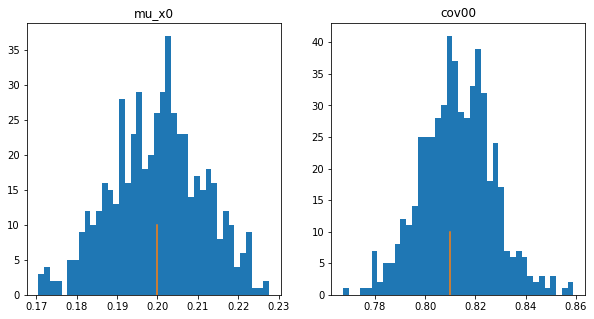

In [39]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_val[i,:], bins=hbins)
    thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_val[i,i,:], bins=hbins)
    thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    thisax.set_title( 'cov%d%d' % (i,i) )

plt.show